In [1]:
import numpy as np
from scipy.special import expit  # sigmoid

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
x_train = x_train.reshape(x_train.shape[0], -1)  # flatten

In [3]:
class RBM:
    def __init__(self, n_visible, n_hidden):
        self.W = np.random.randn(n_visible, n_hidden) * 0.1  # Weights
        self.v_bias = np.zeros(n_visible)  # Visible layer bias
        self.h_bias = np.zeros(n_hidden)  # Hidden layer bias

        # Grads
        self.W_grad = np.zeros(self.W.shape)
        self.vbias_grad = np.zeros(n_visible)
        self.hbias_grad = np.zeros(n_hidden)

        self.n_hidden = n_hidden
        self.n_visible = n_visible

    def sigmoid(self, x):
        # return 1 / (1 + np.exp(-x))
        return expit(x)

    def sample_h_given_v(self, v):
        p = self.sigmoid(np.dot(v, self.W) + self.h_bias) # p(H | v)
        h1_sample = np.random.binomial(1, p) # samples from p(H | v)
        return p, h1_sample

    def sample_v_given_h(self, h):
        p = self.sigmoid(np.dot(h, self.W.T) + self.v_bias)  # p(V | h)
        v1_sample = np.random.binomial(1, p)  # samples from p(V | h)
        return p, v1_sample

    def reconstruct(self, v):
        ph0, h0 = self.sample_h_given_v(v)
        pv1, v1 = self.sample_v_given_h(ph0)
        return pv1
        
    def train(self, batch, learning_rate=0.5):

        batch_size = batch.shape[0]
        v0_sample = batch.reshape(batch_size, -1)

        # Positive phase
        h0_mean, h0_sample = self.sample_h_given_v(v0_sample)
        W_grad = np.dot(v0_sample.T, h0_mean)
        vbias_grad = np.sum(v0_sample, axis=0)
        hbias_grad = np.sum(h0_mean, axis=0)

        # Negative phase
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample)

        W_grad -= np.dot(v1_mean.T, h1_mean)
        vbias_grad = vbias_grad.astype(np.float64) - np.sum(v1_mean, axis=0).astype(np.float64)
        hbias_grad = hbias_grad.astype(np.float64) - np.sum(h1_mean, axis=0).astype(np.float64)

        self.W_grad = W_grad / batch_size
        self.hbias_grad = hbias_grad / batch_size
        self.vbias_grad = vbias_grad / batch_size

        # Update parameters
        self.W += learning_rate * self.W_grad
        self.v_bias += learning_rate * self.vbias_grad
        self.h_bias += learning_rate * self.hbias_grad


        error = np.mean(
            np.sum((v0_sample - v1_mean) ** 2, axis=1), axis=0
        )  # sum of squared error averaged over the batch

        return error

In [4]:
rbm = RBM(784, 100)


selected_imgs = x_train[[1, 6, 5, 12, 26, 35, 62, 52, 46, 4]]

def get_batches(data, batch_size):
    assert batch_size > 0 and batch_size <= len(data)
    num_batches = math.ceil(data.shape[0] / batch_size)
    for batch_num in range(num_batches):
        yield data[batch_num * batch_size : (batch_num + 1) * batch_size]

In [5]:
from time import time
import math

start_time = time()

for i in range(10): # epochs
    training_error = 0
    for batch in get_batches(x_train, batch_size=50):
        training_error += rbm.train(batch)

    print("Training error: ", training_error, " | ",  "Training time: ", time() - start_time)

Training error:  27463.51388249456  |  Training time:  8.015983819961548
Training error:  21083.321280458036  |  Training time:  14.332769870758057
Training error:  19749.07000902881  |  Training time:  20.37172794342041
Training error:  19127.153609355144  |  Training time:  26.274585962295532
Training error:  18716.484464810892  |  Training time:  32.132131814956665
Training error:  18493.712960287397  |  Training time:  38.113117933273315
Training error:  18365.82108522007  |  Training time:  43.95256781578064
Training error:  18253.022466351078  |  Training time:  50.110790967941284
Training error:  18162.456086477003  |  Training time:  56.24071979522705
Training error:  18042.172123457945  |  Training time:  62.22619390487671


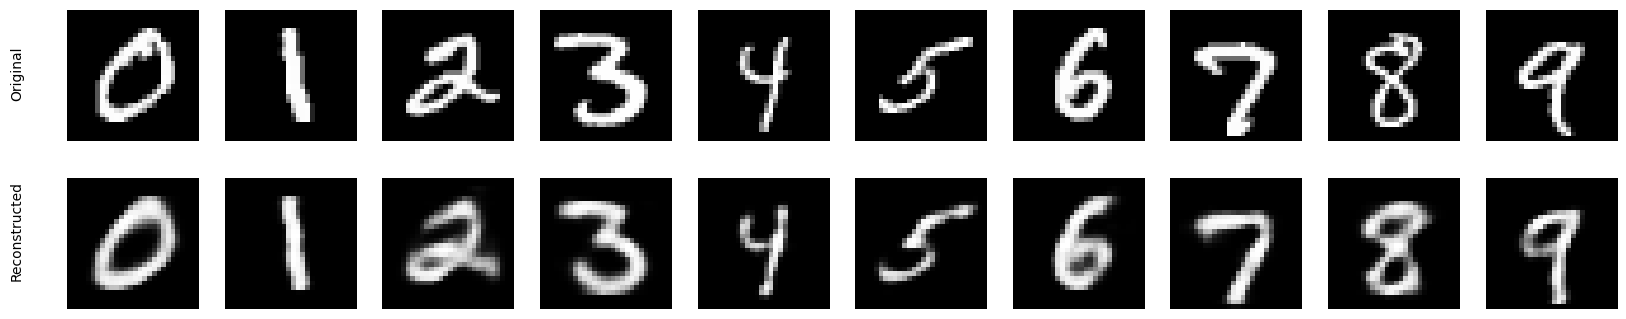

In [6]:
import matplotlib.pyplot as plt

def plot_images(rbm, images):
    num_images = len(images)
    plt.figure(figsize=(2 * num_images, 4))

    for i, image in enumerate(images):
        # Plot original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Plot reconstructed images
        plt.subplot(2, num_images, num_images + i + 1)
        reconstructed_image = rbm.reconstruct(image.reshape(28 * 28)).reshape(28, 28)
        plt.imshow(reconstructed_image, cmap="gray")
        plt.axis("off")

    plt.figtext(0.1, 0.65, "Original", ha="center", rotation="vertical")
    plt.figtext(0.1, 0.20, "Reconstructed", ha="center", rotation="vertical")

    plt.show()

plot_images(rbm, selected_imgs)

The reconstructed image is a "best guess" of the original input based on the features learned by the DBN.
If a DBN reconstructs images accurately, it indicates that it has learned meaningful features.

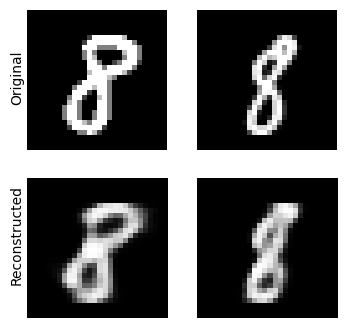

In [7]:
new_images = x_train[[245, 300]]

plot_images(rbm, new_images)

# Implementing DBN

In [8]:
class DBN:
    def __init__(self, n_visible, sizes=[100, 100]):
        self.rbms = []
        self.n_layers = len(sizes)

        # Initialize RBMs for each layer
        for i in range(self.n_layers):
            n_input = n_visible if i == 0 else sizes[i - 1]
            self.rbms.append(RBM(n_input, sizes[i]))

    def pretrain(self, data, epochs=10, batch_size=50, learning_rate=0.1):
        input_data = data

        for rbm in self.rbms:
            print("Pre-training layer...")
            start_time = time()
            for epoch in range(epochs):
                training_error = 0
                for batch in get_batches(input_data, batch_size):
                    training_error += rbm.train(batch, learning_rate=learning_rate)
                print(f"Epoch {epoch+1}, Training error: {training_error}")
            print(f"Layer pre-trained in {time() - start_time} seconds")

            # Use the learned representations (hidden activations) as input for the next layer
            _, input_data = rbm.sample_h_given_v(input_data)

In [9]:
dbn = DBN(n_visible=784, sizes=[100, 100])

In [10]:
dbn.pretrain(data=x_train, epochs=3, batch_size=50, learning_rate=0.1)

Pre-training layer...
Epoch 1, Training error: 26574.500725103277
Epoch 2, Training error: 19656.32376869614
Epoch 3, Training error: 18238.90160799931
Layer pre-trained in 20.349689960479736 seconds
Pre-training layer...
Epoch 1, Training error: 10284.843292704118
Epoch 2, Training error: 7124.666412321912
Epoch 3, Training error: 6473.466867107526
Layer pre-trained in 5.9231321811676025 seconds


# Fine Tuning the DBN

In [11]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

In [12]:
def fine_tune_dbn(dbn, x_train, y_train, epochs=10, batch_size=50, learning_rate=0.1):
    n_classes = 10  
    n_samples, n_features = x_train.shape
    # Randomly initialize weights and biases for the softmax layer
    softmax_weights = np.random.randn(dbn.rbms[-1].n_hidden, n_classes) * 0.1
    softmax_biases = np.zeros(n_classes)

    # Convert labels to one-hot encoding
    y_train_onehot = np.eye(n_classes)[y_train]

    for epoch in range(epochs):
        for batch_idx in range(0, n_samples, batch_size):
            # Get the batch
            batch_x = x_train[batch_idx : batch_idx + batch_size]
            batch_y = y_train_onehot[batch_idx : batch_idx + batch_size]

            # Forward pass through the DBN to get the features
            dbn_features = batch_x
            for rbm in dbn.rbms:
                dbn_features, _ = rbm.sample_h_given_v(dbn_features)

            # Forward pass through the softmax layer
            logits = np.dot(dbn_features, softmax_weights) + softmax_biases
            probs = softmax(logits)

            # Compute cross-entropy loss and gradients
            loss = -np.mean(np.sum(batch_y * np.log(probs + 1e-8), axis=1))
            grad_logits = (probs - batch_y) / batch_size

            # Backpropagation: compute gradients
            grad_softmax_weights = np.dot(dbn_features.T, grad_logits)
            grad_softmax_biases = np.sum(grad_logits, axis=0)

            # Update weights and biases
            softmax_weights -= learning_rate * grad_softmax_weights
            softmax_biases -= learning_rate * grad_softmax_biases

        print(f"Epoch {epoch+1}, Loss: {loss}")

    return softmax_weights, softmax_biases

In [13]:
softmax_weights, softmax_biases = fine_tune_dbn(
    dbn, x_train, y_train, epochs=10, batch_size=50, learning_rate=0.1
)

Epoch 1, Loss: 0.19823236328460933
Epoch 2, Loss: 0.16116774539969106
Epoch 3, Loss: 0.1442154415668443
Epoch 4, Loss: 0.1332463631593757
Epoch 5, Loss: 0.12522320790994798
Epoch 6, Loss: 0.11900234846820741
Epoch 7, Loss: 0.1140055089464379
Epoch 8, Loss: 0.10988837531458122
Epoch 9, Loss: 0.10642641410099182
Epoch 10, Loss: 0.10346517456807595


We started with a great value of loss thanks to pre-training.

In [14]:
def predict(dbn, softmax_weights, softmax_biases, image):
    # Ensure the image is correctly shaped - flatten if it's 2D
    if image.ndim == 2:
        image = image.reshape(1, -1)

    # Pass the image through the pretrained DBN to get features
    dbn_features = image
    for rbm in dbn.rbms:
        dbn_features, _ = rbm.sample_h_given_v(dbn_features)

    # Forward pass through the softmax layer
    logits = np.dot(dbn_features, softmax_weights) + softmax_biases
    probs = softmax(logits)

    # Return the class with the highest probability
    return np.argmax(probs, axis=1)

Predicted class: [8]


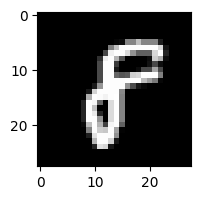

In [15]:
# Test the model

image = x_test[355]
plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray")
predicted_class = predict(dbn, softmax_weights, softmax_biases, image)
print("Predicted class:", predicted_class)

In [16]:
def evaluate_model(dbn, softmax_weights, softmax_biases, x_test, y_test):
    predictions = np.array(
        [predict(dbn, softmax_weights, softmax_biases, img) for img in x_test]
    )
    accuracy = np.mean(predictions.flatten() == y_test)
    print(f"Model Accuracy: {accuracy * 100:.2f}%")


evaluate_model(dbn, softmax_weights, softmax_biases, x_test, y_test)

Model Accuracy: 92.06%


What is next?

1. Feature extraction
- DBNs are excellent at learning hierarchical representations of data. These representations can be used as features in various machine learning tasks.
2. Classification
- Once a DBN has been trained, it can be fine-tuned for classification tasks. In the context of MNIST, this would involve adding a classification layer (e.g., a softmax layer) on top of the DBN and then training the network in a supervised manner to classify the digits.
3. Generative Models
- A well-trained DBN is a generative model that can sample from the distribution of the training data. This means you can use it to generate new data samples that resemble the original dataset.
4. Anomaly Detection
- Because DBNs learn the probability distribution of the input data, they can be used to detect anomalies or outliers.